In [9]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torch import optim
from sklearn.model_selection import train_test_split;

In [10]:
from argparse import Namespace

modelArgs = Namespace(
    
data_csv = 'timeSeriesData.csv',
model_state_file = "model.pth",
seed = 1300,
learning_rate = 0.001,
# dropout_p = 0.1,
batch_size = 1,
num_epochs = 40,
device = "cuda" if torch.cuda.is_available() else "cpu",

);

Data preparation 

In [11]:
def rnn_data_preparation(dataframe,window_size):
    df = dataframe.copy(deep = True);
    # df = df.set_index('date');
    for i in range(1 , window_size+1):
        df[f'meantemp(t-{i})'] = df['meantemp'].shift(i);
    df = df.dropna();
    return df;


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


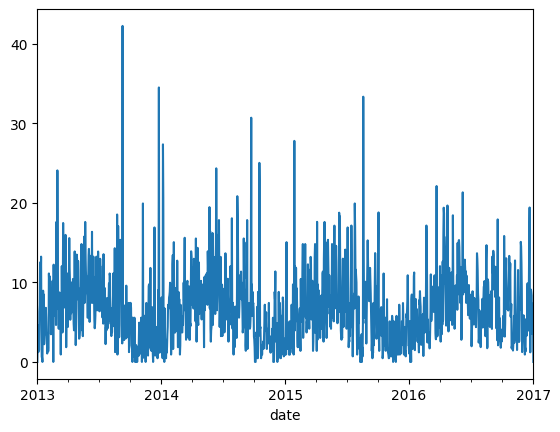

In [12]:
df = pd.read_csv("data/DailyDelhiClimateTrain.csv", parse_dates=['date'] , index_col = "date");
df.tail();
df['wind_speed'].plot()
df
# using mean rolling 
# plt.plot(df.index , df['meantemp'].rolling(window=6).mean())


##### Creating the data loader #####

In [13]:
prepared_data = rnn_data_preparation(df[['meantemp']],6);
prepared_data = prepared_data[prepared_data.columns[::-1]];
prepared_data

,meantemp(t-6),meantemp(t-5),meantemp(t-4),meantemp(t-3),meantemp(t-2),meantemp(t-1),meantemp
date,,,,,,,
2013-01-07,10.000000,7.400000,7.166667,8.666667,6.000000,7.000000,7.000000
2013-01-08,7.400000,7.166667,8.666667,6.000000,7.000000,7.000000,8.857143
2013-01-09,7.166667,8.666667,6.000000,7.000000,7.000000,8.857143,14.000000
2013-01-10,8.666667,6.000000,7.000000,7.000000,8.857143,14.000000,11.000000
2013-01-11,6.000000,7.000000,7.000000,8.857143,14.000000,11.000000,15.714286
...,...,...,...,...,...,...,...
2016-12-28,17.285714,15.550000,17.318182,14.000000,17.142857,16.850000,17.217391
2016-12-29,15.550000,17.318182,14.000000,17.142857,16.850000,17.217391,15.238095
2016-12-30,17.318182,14.000000,17.142857,16.850000,17.217391,15.238095,14.095238


Creating Data set

In [14]:
from torch.utils.data import Dataset, DataLoader

class DataSet(Dataset):
    def __init__(self , dataFrame:pd.DataFrame , x_columns:list , y_column:list) -> None:
        super().__init__();
        self.x_data = dataFrame[x_columns];
        self.y_data = dataFrame[y_column];
    
    
    def __getitem__(self, index):
        x_data = torch.tensor(self.x_data.iloc[index]);
        y_data = torch.tensor(self.y_data.iloc[index]);
        return x_data , y_data;

    def __len__(self):
        return len(self.x_data);


# X_train, X_test, y_train, y_test = train_test_split(prepared_data[prepared_data.columns.drop(['meantemp'])],prepared_data['meantemp'] , test_size=0.2 , random_state=42)
limit = int(0.8*len(prepared_data));

train = prepared_data.iloc[:limit];
test = prepared_data.iloc[limit:];

train_data_set = DataSet(train,prepared_data.columns.drop(['meantemp']),'meantemp');
test_data_set = DataSet(test,prepared_data.columns.drop(['meantemp']),'meantemp');


Creating DataLoader

In [15]:
dataLoader = DataLoader(train_data_set , batch_size= modelArgs.batch_size)

In [16]:
class Rnn(nn.Module):

    def __init__(self,input_size , hidden_size , output_size , batch_size = modelArgs.batch_size):

        super(Rnn,self).__init__();
        self.hidden_size = hidden_size;
        self.input_size = input_size;
        self.output_size = output_size;
        self.batch_size = batch_size
        self.i2h = nn.Linear(self.input_size , self.hidden_size);
        self.h2h = nn.Linear(self.hidden_size , self.hidden_size);
        self.h2o = nn.Linear(self.hidden_size , self.output_size);
        # self.sigmoid = nn.Sigmoid();
    
    def forward(self,input_tensor,hidden_tensor):

        # print(f'input_tensor with size == {input_tensor.size()} \n');

        # print(f'hidden_tensor with size == {hidden_tensor.size()} \n');
        
        input_hidden = self.i2h(input_tensor);
        # print(f'input_hidden with size == {input_tensor.size()} \n');
        
        hidden_hidden = self.h2h(hidden_tensor);
        # print(f'hidden_hidden with size == {input_tensor.size()} \n');

        combined = (input_hidden + hidden_hidden);
        # print(f'combined_tensor with size == {combined.size()} \n');
        
        output = self.h2o(combined);
        # print(f'hidden size from I2H is {hidden.size()}');
        # output = self.sigmoid(self.i2o(combined));
        # print(f'output size from h2O is {output.size()}');

        return output,combined;


    def init_hidden(self, batch_size = modelArgs.batch_size):
        return torch.zeros(batch_size,self.hidden_size , requires_grad=False);



def train(model: Rnn, data: DataLoader, epochs: int, optimizer: optim.Optimizer, loss_fn: nn.Module):

    train_losses = {};
    model.train();
    for epoch in range(epochs):
            epoch_losses = list();
            for X, Y in data:
                # skip batch if it doesnt match with the batch_size
                # print(X.shape[0]);
                if X.shape[0] != modelArgs.batch_size:
                    continue

                hidden = model.init_hidden(batch_size=modelArgs.batch_size)

                # send tensors to device
                X, Y, hidden = X.to(modelArgs.device), Y.to(modelArgs.device), hidden.to(modelArgs.device)

                # 2. clear gradients
                model.zero_grad()

                loss = 0
                # print(f'the shape is : {X.shape[1]}');

                for c in range(X.shape[1]):

                    # print(f'X size is {X.float()[:, c].reshape(X.shape[0],1).size()}');
                    
                    # print();

                    # print(f'Hidden size is {hidden.size()}');

                    out, hidden = model(X.float()[:, c].reshape(X.shape[0],1), hidden);

                    # loss += l
                
                # print(Y.long());

                loss = loss_fn(out, Y.float())
                # 4. Compte gradients gradients
                loss.backward()

                # 5. Adjust learnable parameters
                # clip as well to avoid vanishing and exploding gradients
                nn.utils.clip_grad_norm_(model.parameters(), 3)
                optimizer.step()
            
                epoch_losses.append(loss.detach().item() / X.shape[1])

            train_losses[epoch] = torch.tensor(epoch_losses).mean();

    return model;


rnn = Rnn(1 , 128 , 1);
loss = nn.MSELoss();
optimizer = optim.RMSprop(rnn.parameters(), lr = 0.001);
model = train(rnn,dataLoader,20,optimizer=optimizer,loss_fn=loss);


/tmp/ipykernel_34721/3696815292.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_data = torch.tensor(self.x_data.iloc[index]);
/home/raouf/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [20]:
# classifier(x = torch.stack((torch.tensor(vectorizer.vectorize("this is a bad movie ",267)).to(modelArgs.device),torch.tensor(vectorizer.vectorize("The movie is not good enough",267)).to(modelArgs.device))))

# torch.save(model.state_dict(), 'model.pth')


total_acc = 0;

model.eval();
# print(dataset.test_size)
    

for X,Y in DataLoader(test_data_set): 

    hidden = model.init_hidden();

    X, Y , hidden = X.to(modelArgs.device), Y.to(modelArgs.device),hidden.to(modelArgs.device);

    for c in range(X.shape[1]):

            # print(f'X size is {X.float()[:, c].reshape(X.shape[0],1).size()}');

            # print(f'Hidden size is {hidden.size()}');

            out, hidden = model(X.float()[:, c].reshape(X.shape[0],1), hidden);
            # print(out);
            print(Y);



    # y_pred = model(X.float() , hidden.float());
    print(f'Prediction is {out}');

    print(f'True value is : {Y}');

    # print(y_pred)
    
#     print(torch.sigmoid(y_pred));
    
#     print(y_pred)
    
    # loss = loss(y_pred.squeeze().float(),Y.float());
    
    # print(loss)

        
#         running_acc += (acc_batch - running_acc) / (batch_index + 1)

# print(total_acc*100 / len(test_data_set))

/tmp/ipykernel_34721/3696815292.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_data = torch.tensor(self.x_data.iloc[index]);


tensor([23.9375], dtype=torch.float64)
tensor([23.9375], dtype=torch.float64)
tensor([23.9375], dtype=torch.float64)
tensor([23.9375], dtype=torch.float64)
tensor([23.9375], dtype=torch.float64)
tensor([23.9375], dtype=torch.float64)
Prediction is tensor([[23.8738]], grad_fn=<AddmmBackward0>)
True value is : tensor([23.9375], dtype=torch.float64)
tensor([26.3125], dtype=torch.float64)
tensor([26.3125], dtype=torch.float64)
tensor([26.3125], dtype=torch.float64)
tensor([26.3125], dtype=torch.float64)
tensor([26.3125], dtype=torch.float64)
tensor([26.3125], dtype=torch.float64)
Prediction is tensor([[23.8010]], grad_fn=<AddmmBackward0>)
True value is : tensor([26.3125], dtype=torch.float64)
tensor([26.1875], dtype=torch.float64)
tensor([26.1875], dtype=torch.float64)
tensor([26.1875], dtype=torch.float64)
tensor([26.1875], dtype=torch.float64)
tensor([26.1875], dtype=torch.float64)
tensor([26.1875], dtype=torch.float64)
Prediction is tensor([[25.5901]], grad_fn=<AddmmBackward0>)
True val